In [1]:
from openslide import open_slide 
from openslide import __library_version__ as openslide_version
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from skimage.color import rgb2gray

In [2]:
plt.rcParams['image.cmap'] = 'Greys'

In [3]:
openslide_version

'3.4.1'

In [4]:
# !pip install ipython==6.2.0

In [5]:
# !gsutil ls gs://applied-dl-sj/camelyon/source_data/

In [6]:
os.listdir('../test/')

['temp_mask.png',
 'tumor_059.tif',
 'tumor_091.tif',
 'temp_mask.tif',
 'tumor_091_mask.tif',
 'tumor_img_meta_info.pkl',
 'temp_mask.jpg',
 'test_kitten.png']

In [7]:
GC_SOURCE_DIR = 'gs://applied-dl-sj/camelyon/source_data/'
TEST_LOCAL_DIR = '../test/'

In [8]:
slide_filename = 'tumor_091.tif'
tumor_mask_filename = 'tumor_091_mask.tif'

In [9]:
for filename in [slide_filename, tumor_mask_filename]:
    source_filepath = os.path.join(GC_SOURCE_DIR, filename)
    dest_filepath = os.path.join(TEST_LOCAL_DIR, filename)
    
    if not os.path.exists(dest_filepath):
        tic = time.time()
        print('Downloading {} ...'.format(source_filepath))
        !gsutil cp $source_filepath $dest_filepath
        toc = time.time()
        print('Took {} mins\n'.format((toc - tic)/60))

In [10]:
slide = open_slide(os.path.join(TEST_LOCAL_DIR, slide_filename))
tumor_mask = open_slide(os.path.join(TEST_LOCAL_DIR, tumor_mask_filename))

In [11]:
len(slide.level_dimensions)

8

In [12]:
slide.level_dimensions

((61440, 53760),
 (30720, 26880),
 (15360, 13440),
 (7680, 6720),
 (3840, 3360),
 (1920, 1680),
 (960, 840),
 (480, 420))

In [13]:
slide.level_downsamples

(1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0)

In [14]:
# Sanity check 1

for i, dims in enumerate(slide.level_dimensions):
    print('Level {}, dim: {}, factor: {}'.format(i, dims, slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i] == dims

Level 0, dim: (61440, 53760), factor: 1.0
Level 1, dim: (30720, 26880), factor: 2.0
Level 2, dim: (15360, 13440), factor: 4.0
Level 3, dim: (7680, 6720), factor: 8.0
Level 4, dim: (3840, 3360), factor: 16.0
Level 5, dim: (1920, 1680), factor: 32.0
Level 6, dim: (960, 840), factor: 64.0
Level 7, dim: (480, 420), factor: 128.0


In [15]:
# Sanity check 2

for i, dims in enumerate(slide.level_dimensions):
    assert (slide.level_downsamples[i] * np.array(dims)
            == np.array(slide.level_dimensions[0])).all()

In [16]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

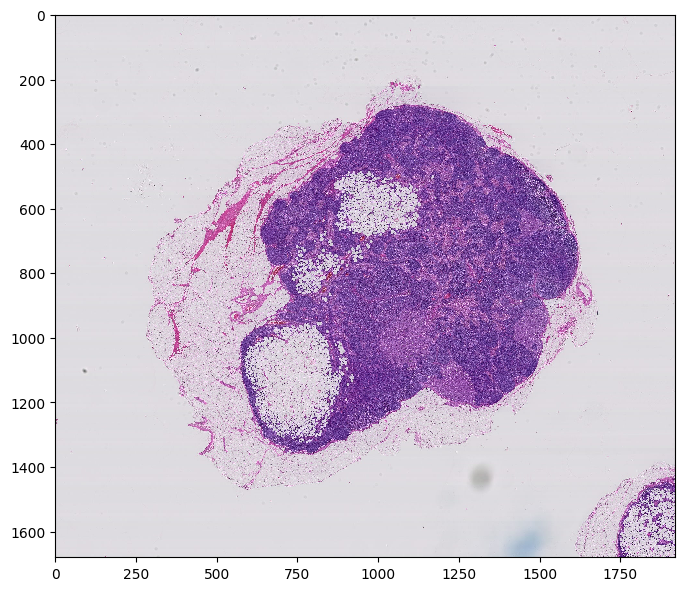

In [17]:
# Example: read the entire slide at level 5

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to the tissue mask to see if the same region contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

plt.figure(figsize=(8,8), dpi=100)
plt.imshow(slide_image)

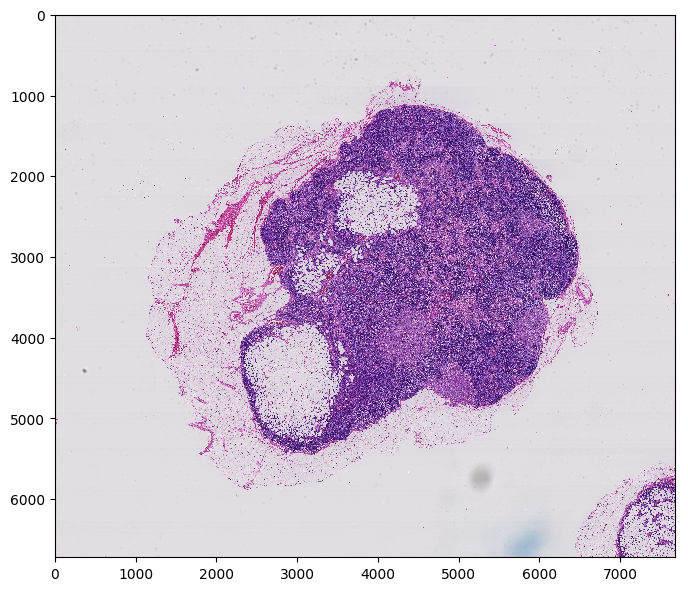

In [18]:
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=3, 
                         width=slide.level_dimensions[3][0], 
                         height=slide.level_dimensions[3][1])

plt.figure(figsize=(8,8), dpi=100)
plt.imshow(slide_image)

In [19]:
slide_image.shape

(6720, 7680, 3)

In [25]:

# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])

# mask_image = mask_image[:, :, 0]

# plt.figure(figsize=(5,5), dpi=100)
# plt.imshow(mask_image)

In [27]:
len(mask_image.shape)

3

In [24]:
mask_image[1000:1100, 1000:1100].mean()

0.6685

In [ ]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [ ]:
pd.Series(mask_image.flatten()).value_counts()

In [ ]:
plt.imshow(mask_image)

In [ ]:
tumor_mask.level_downsamples[7]

In [ ]:
tumor_mask.level_dimensions[7]

In [ ]:
region = read_slide(tumor_mask, x=0, y=0, level=7, width=480, height=420)[:,:,0]
plt.imshow(region)

In [ ]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.
fig, ax = plt.subplots()

#fig.patch.set_facecolor('black')
region = read_slide(tumor_mask, x=350 * 128, y=120 * 128, level=7, width=50, height=80)[:,:,0]

ax.imshow(region)

In [ ]:
region.sum()

In [ ]:
slide_image.max()

In [ ]:
img_gray = rgb2gray(slide_image)

In [ ]:
plt.imshow(img_gray)

In [ ]:
np.where(img_gray <= 0.8)

In [ ]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

In [ ]:
tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

In [ ]:
tissue_pixels_new = find_tissue_pixels(slide_image, intensity=0.83)
percent_tissue_new = len(tissue_pixels_new) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels_new), percent_tissue_new))

In [ ]:
def apply_mask(im, mask, color=(255, 0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

In [ ]:
tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

In [ ]:
tissue_regions = apply_mask(slide_image, tissue_pixels_new)
plt.imshow(tissue_regions)

In [ ]:
plt.imshow(slide_image)